In [1]:
import numpy as np
import os

def unpickle(file_path):
    """
    Unpickle a file and return the contents as a dictionary.

    Args:
        file_path (str): The path to the file to unpickle.

    Returns:
        dict: The contents of the unpickled file as a dictionary.
    """
    import pickle
    with open(file_path, 'rb') as f:
        unpickled_data = pickle.load(f, encoding='bytes')
    return unpickled_data



def softmax(logits):
    """
    Compute the softmax function for a set of logits.

    Args:
        logits (ndarray): A 2D array of shape (num_classes, num_samples) containing the logits.

    Returns:
        ndarray: A 2D array of shape (num_classes, num_samples) containing the softmax probabilities.
    """
    logits = logits.T
    assert len(logits.shape) == 2
    max_logits = np.max(logits, axis=1)
    max_logits = max_logits[:, np.newaxis]
    exp_logits = np.exp(logits - max_logits)
    sum_exp_logits = np.sum(exp_logits, axis=1)
    sum_exp_logits = sum_exp_logits[:, np.newaxis]
    softmax_probs = exp_logits / sum_exp_logits
    return softmax_probs.T


def relu(input_data):
    """
    Compute the rectified linear unit (ReLU) activation function for a set of input data.

    Args:
        input_data (ndarray): A 2D array of shape (num_features, num_samples) containing the input data.

    Returns:
        ndarray: A 2D array of shape (num_features, num_samples) containing the ReLU activations.
    """
    return np.where(input_data > 0, input_data, 0)



def load_batch(file_path):
    """
    Load a batch of data from a file and return the data and labels.

    Args:
        file_path (str): The path to the file to load.

    Returns:
        tuple: A tuple containing the data and labels as 2D arrays.
    """
    unpickled_data = unpickle(file_path)
    return unpickled_data[b'data'], unpickled_data[b'labels']


def load_files(file_names, one_hot=True):
    """
    Load a set of data files and return the concatenated data and labels.

    Args:
        file_names (list): A list of file paths to load.
        one_hot (bool): Whether to use one-hot encoding for the labels.

    Returns:
        tuple: A tuple containing the concatenated data and labels as 2D arrays.
    """
    data, labels = [], []
    for file_path in file_names:
        loaded_data, loaded_labels = load_batch(file_path)
        data.append(loaded_data)
        labels.append(loaded_labels)
    if one_hot:
        return np.concatenate(data), one_hot_encoder(np.concatenate(labels))
    return np.concatenate(data), np.concatenate(labels)


def one_hot_encoder(y, num_classes=10):
    return np.eye(num_classes)[np.array(y, dtype='int')]


def load_data(train_files, validation_files, test_files):
    """
    Load a set of data files for training, validation, and testing, and normalize the data.

    Args:
        train_files (list): A list of file paths containing the training data.
        validation_files (list): A list of file paths containing the validation data.
        test_files (list): A list of file paths containing the test data.

    Returns:
        tuple: A tuple containing the normalized training, validation, and test data and labels, as well as the mean and standard deviation used for normalization.
    """
    train_data, train_labels = load_files(train_files)
    validation_data, validation_labels = load_files(validation_files)
    test_data, test_labels = load_files(test_files)

    mean = train_data.mean()
    std = train_data.std()
    train_data = (train_data - mean) / std
    validation_data = (validation_data - mean) / std
    test_data = (test_data - mean) / std

    return train_data.T, validation_data.T, test_data.T, train_labels.T, validation_labels.T, test_labels.T, mean, std


def get_data(data_folder):
    """
    Load the CIFAR-10 dataset from a specified folder.

    Args:
        data_folder (str): The path to the folder containing the CIFAR-10 data files.

    Returns:
        tuple: A tuple containing the normalized training, validation, and test data and labels, as well as the mean and standard deviation used for normalization.
    """
    train_files = [os.path.join(data_folder, 'cifar-10-batches-py', f)
                   for f in ['data_batch_1']]
    val_files = [os.path.join(data_folder, 'cifar-10-batches-py', f)
                 for f in ['data_batch_2']]
    test_files = [os.path.join(data_folder, 'cifar-10-batches-py', f)
                  for f in ['test_batch']]
    try:
        return load_data(train_files, val_files, test_files)
    except FileNotFoundError:
        print("Error: One or more data files not found.")
    except ValueError:
        print("Error: One or more data files are not in the expected format.")


def flip(image):
    """
    Flip an image horizontally.

    Args:
        image (ndarray): A 3D array representing the image to flip.

    Returns:
        ndarray: A 3D array representing the flipped image.
    """
    flipped_image = image.copy()
    for i in range(32 * 3 - 1):
        flipped_image[i*32:(i+1)*32] = flipped_image[i*32:(i+1)*32][::-1]
    return flipped_image


def get_all_data(dir_path, validation_n=5000):
    """
    Load all data files for training, validation, and testing, and normalize the data.

    Args:
        dir_path (str): The path to the directory containing the CIFAR-10 data files.
        validation_n (int): The number of samples to use for validation.

    Returns:
        tuple: A tuple containing the normalized training, validation, and test data and labels, as well as the mean and standard deviation used for normalization.
    """
    train_data = []
    train_labels = []
    validation_data = []
    validation_labels = []
    test_data = []
    test_labels = []

    for i in range(1, 6):
        file_path = os.path.join(dir_path, f'data_batch_{i}')
        try:
            loaded = unpickle(file_path)
        except FileNotFoundError:
            print(f"Error: File not found: {file_path}")
            return
        except ValueError:
            print(f"Error: File not in expected format: {file_path}")
            return
        train_data.append(loaded[b'data'])
        train_labels.append(loaded[b'labels'])
    file_path = os.path.join(dir_path, 'test_batch')
    try:
        loaded = unpickle(file_path)
    except FileNotFoundError:
        print(f"Error: File not found: {file_path}")
        return
    except ValueError:
        print(f"Error: File not in expected format: {file_path}")
        return
    test_data = np.array(loaded[b'data'])
    test_labels = np.eye(10)[np.array(loaded[b'labels'])]  # one-hot coding
    train_data = np.concatenate(train_data)
    train_labels = np.eye(10)[np.concatenate(train_labels)]  # one-hot coding
    mean = train_data.mean()
    std = train_data.std()
    train_data = (train_data - mean) / std
    test_data = (test_data - mean) / std
    validation_data = train_data[:validation_n]
    validation_labels = train_labels[:validation_n]
    train_data = train_data[validation_n:]
    train_labels = train_labels[validation_n:]
    return train_data.T, validation_data.T, test_data.T, train_labels.T, validation_labels.T, test_labels.T, mean, std


if __name__ == '__main__':
    x_train, x_val, x_test, y_train, y_val, y_test, mean, std = get_data(
        os.path.join('datasets'))

    print(x_train.shape, x_val.shape, x_test.shape)
    print(y_train.shape, y_val.shape, y_test.shape)
    print(x_train.mean(), x_train.std())
    print(x_test.mean(), x_test.std())

    print(x_val.mean(), x_val.std())


(3072, 10000) (3072, 10000) (3072, 10000)
(10, 10000) (10, 10000) (10, 10000)
-6.106226635438361e-17 1.0000000000000007
0.007580614388947589 0.9948807690405734
-0.003204818012514591 0.9966486046311599


epoch1/12


100%|█████████▉| 500/501 [00:05<00:00, 97.70it/s] 


epoch2/12


100%|█████████▉| 500/501 [00:04<00:00, 106.86it/s]


epoch3/12


100%|█████████▉| 500/501 [00:05<00:00, 99.45it/s] 


epoch4/12


100%|█████████▉| 500/501 [00:05<00:00, 92.82it/s] 


epoch5/12


100%|█████████▉| 500/501 [00:03<00:00, 143.21it/s]


epoch6/12


100%|█████████▉| 500/501 [00:04<00:00, 109.99it/s]


epoch7/12


100%|█████████▉| 500/501 [00:04<00:00, 105.69it/s]


epoch8/12


100%|█████████▉| 500/501 [00:04<00:00, 113.60it/s]


epoch9/12


100%|█████████▉| 500/501 [00:04<00:00, 119.61it/s]


epoch10/12


100%|█████████▉| 500/501 [00:03<00:00, 138.61it/s]


epoch11/12


100%|█████████▉| 500/501 [00:03<00:00, 139.21it/s]


epoch12/12


100%|█████████▉| 500/501 [00:03<00:00, 140.37it/s]


[1.7492790897929855, 1.7492790897929855, 0.3802]


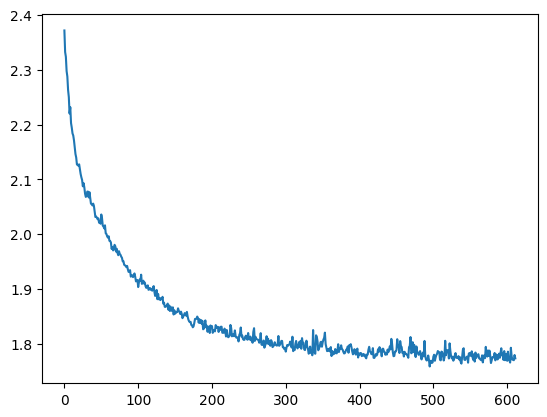

In [2]:
from calendar import leapdays
from math import gamma
from turtle import forward

from matplotlib.ft2font import LOAD_LINEAR_DESIGN
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm



class Dense_layer:
    def __init__(self, n_input, n_units, activation, lambda_, use_batch_norm, after=False, adam=False) -> None:
        self.n_input = n_input
        self.n_units = n_units
        assert activation in ['relu', 'softmax']
        self.activation = activation
        self.W = np.random.normal(0, 1/np.sqrt(n_input), (n_units, n_input))
        self.b = np.zeros(n_units)
        self.gradient = (None, None)
        self.lambda_ = lambda_
        self.use_bn = use_batch_norm
        if self.use_bn:
            self.mu = np.zeros(n_units)
            self.mu_average = np.zeros(n_units)
            self.v = np.ones(n_units)
            self.v_average = np.ones(n_units)
            self.gamma = np.ones(n_units)
            self.beta = np.zeros(n_units)
            self.alpha = 0.9
        self.after = after
        self.adam_m = [0,  0, 0, 0]
        self.adam_v = [0, 0, 0, 0]
        self.t = 1
        self.adam = adam

    def forward(self, X, test, set_average=False):
        self.input = X
        h = ((self.W @ X).T + self.b).T
        if self.after and self.use_bn:
            h = relu(h)
        if self.use_bn:
            if test:
                mean = self.mu_average
                var = self.v_average
            else:
                self.s = h.copy()
                n = X.shape[1]
                mean = np.mean(h, axis=1)
                var = np.var(h, axis=1)
                self.mu = mean
                self.v = var
            if set_average:
                self.mu_average = mean
                self.v_average = var
            h = np.diag(1 / np.sqrt(var+1e-6)) @ (h.T - mean).T
            self.s_hat = h.copy()
            h = ((h.T * self.gamma) + self.beta).T

        if self.after and self.use_bn:
            self.output = h
            return h
        if self.activation == 'relu':
            self.output = relu(h)
        else:
            self.output = softmax(h)
        return self.output
    
    def _batch_norm_back(self, g_in):
        n = g_in.shape[1]
        one_vector_col = np.ones([n, 1])
        one_vector_row = np.ones([1, n])
        
        inv_sqrt_variance = 1 / np.sqrt(self.v + 1e-6)
        inv_variance_1_5 = 1 / np.power(self.v + 1e-6, 1.5)
    
        gradient_wrt_norm_1 = (g_in.T * inv_sqrt_variance).T
        gradient_wrt_norm_2 = (g_in.T * inv_variance_1_5).T
    
        diff_input_mean = (self.s.T - self.mu).T
        dot_product = (gradient_wrt_norm_2 * diff_input_mean) @ one_vector_col
    
        mean_gradient = ((gradient_wrt_norm_1 @ one_vector_col) @ one_vector_row) / n
        variance_adjusted_gradient = diff_input_mean * (dot_product @ one_vector_row) / n
        
        return gradient_wrt_norm_1 - mean_gradient - variance_adjusted_gradient


    def backward(self, g_in):
        n_batch = self.input.shape[1]
        self.gradient = [None, None, None, None]
        if self.activation == 'softmax':
            gradient = g_in
            g_W = gradient @ self.input.T / n_batch + 2 * self.lambda_ * self.W
            g_b = np.mean(gradient, axis=1)
            self.gradient[0] = g_W
            self.gradient[1] = g_b

        elif self.activation == 'relu':
            gradient = g_in
            if not self.after:
                gradient = np.where(self.output > 0, gradient, 0)
            if self.use_bn:
                g_gamma = np.mean(gradient * self.s_hat, axis=1)
                g_beta = np.mean(gradient, axis=1)
                self.gradient[2] = g_gamma
                self.gradient[3] = g_beta
                n = gradient.shape[1]
                gradient = (gradient.T * self.gamma).T
                gradient = self._batch_norm_back(gradient)
            if self.after:
                gradient = np.where(self.s > 0, gradient, 0)
            g_W = gradient @ self.input.T / n_batch + 2 * self.lambda_ * self.W
            g_b = np.mean(gradient, axis=1)
            self.gradient[0] = g_W
            self.gradient[1] = g_b

        return self.W.T @ gradient

    def update(self, leraning_rate):
        if type(self.gradient[0]) == type(None) or type(self.gradient[1]) == type(None):
            raise Exception('First you must calculate gradient')
        if not self.adam:
            self.W -= leraning_rate * self.gradient[0]
            self.b -= leraning_rate * self.gradient[1]
            if self.use_bn:
                self.gamma -= leraning_rate * self.gradient[2]
                self.beta -= leraning_rate * self.gradient[3]
                self.mu_average = self.alpha * \
                    self.mu_average + (1-self.alpha) * self.mu
                self.v_average = self.alpha * \
                    self.v_average + (1-self.alpha) * self.v
        if self.adam:
            m_hat = [0, 0, 0, 0]
            v_hat = [0, 0, 0, 0]
            for i in range(4 if self.use_bn else 2):
                self.adam_m[i] = 0.9 * self.adam_m[i] + 0.1 * self.gradient[i]
                self.adam_v[i] = 0.999 * self.adam_v[i] + \
                    0.001 * np.square(self.gradient[i])
                m_hat[i] = self.adam_m[i] / (1 - (0.9)**self.t)
                v_hat[i] = self.adam_v[i] / (1 - (0.999)**self.t)
            self.W -= leraning_rate * m_hat[0] / (np.sqrt(v_hat[0])+1e-8)
            self.b -= leraning_rate * m_hat[1] / (np.sqrt(v_hat[1])+1e-8)
            if self.use_bn:
                self.gamma -= leraning_rate * \
                    m_hat[2] / (np.sqrt(v_hat[2])+1e-8)
                self.beta -= leraning_rate * \
                    m_hat[3] / (np.sqrt(v_hat[3])+1e-8)
                self.mu_average = self.alpha * \
                    self.mu_average + (1-self.alpha) * self.mu
                self.v_average = self.alpha * \
                    self.v_average + (1-self.alpha) * self.v
        self.t += 1
        self.gradient = [None, None, None, None]


class Model:
    def __init__(self, n_in, number_of_units, n_out, lambda_, use_bn, after=False, adam=False) -> None:
        if type(number_of_units) != list:
            raise Exception('number of laters per units must be a list!')
        self.layers = []
        if len(number_of_units) == 0:
            self.layers.append(Dense_layer(
                n_in, n_out, 'softmax', lambda_, False, adam=adam))
        else:
            for n in number_of_units:
                self.layers.append(Dense_layer(
                    n_in, n, 'relu', lambda_, use_bn, after, adam=adam))
                n_in = n
            self.layers.append(Dense_layer(
                n_in, n_out, 'softmax', lambda_, False, adam=adam))
        self.use_bn = use_bn

    def _forward(self, X, is_test):
        x = X
        for l in self.layers:
            x = l.forward(x, is_test)
        return x

    def set_average(self, X):
        x = X
        for l in self.layers:
            x = l.forward(x, False, True)
        return x

    def _backward(self, Y, P):
        G = -(Y - P)
        for l in self.layers[::-1]:
            G = l.backward(G)

    def _update(self, learning_rate):
        for l in self.layers:
            l.update(learning_rate)

    def _loss(self, Y, P):
        minus_log = -1 * np.log(np.sum(P * Y, axis=0))
        return minus_log.mean()

    def _cost(self, Y, P):
        c = self._loss(Y, P)
        for l in self.layers:
            c += l.lambda_ * np.sum(np.square(l.W))
        return c

    def _accuracy(self, Y, P):
        Y = Y.T
        P = P.T
        y_num = np.argmax(Y, axis=1)
        y_pred = np.argmax(P, axis=1)
        return np.where(y_num == y_pred, 1, 0).sum() / y_num.shape[0]

    def _shuffle(self, X, Y, Z=None):
        n = X.shape[1]
        idx = np.random.permutation(n)
        if type(Z) == type(None):
            return X[:, idx], Y[:, idx]
        return X[:, idx], Y[:, idx], Z[:, idx]

    def _numerical_gradient(self, X, Y):
        h = 1e-6
        G_Ws = []
        G_bs = []
        G_gammas = []
        G_betas = []
        c = self._cost(Y, self._forward(X, False))
        for idx, l in enumerate(self.layers):
            g_w = np.zeros(l.W.shape)
            g_b = np.zeros(l.b.shape)
            w_save = l.W
            b_save = l.b
            for i in range(len(l.b)):
                l.b = b_save.copy()
                l.b[i] += h
                c2 = self._cost(Y, self._forward(X, False))
                g_b[i] = (c2-c) / h
            l.b = b_save
            for i in range(l.W.shape[0]):
                for j in range(l.W.shape[1]):
                    l.W = w_save.copy()
                    l.W[i][j] += h
                    c2 = self._cost(Y, self._forward(X, False))
                    g_w[i][j] = (c2-c) / h
            l.W = w_save
            G_Ws.append(g_w)
            G_bs.append(g_b)
            if self.use_bn and idx < len(self.layers)-1:
                g_gamma = np.zeros(l.gamma.shape)
                g_beta = np.zeros(l.beta.shape)
                gamma_save = l.gamma
                for i in range(len(l.gamma)):
                    l.gamma = gamma_save.copy()
                    l.gamma[i] += h
                    c2 = self._cost(Y, self._forward(X, False))
                    g_gamma[i] = (c2 - c) / h
                l.gamma = gamma_save
                beta_save = l.beta
                for i in range(len(l.beta)):
                    l.beta = beta_save.copy()
                    l.beta[i] += h
                    c2 = self._cost(Y, self._forward(X, False))
                    g_beta[i] = (c2 - c) / h
                l.beta = beta_save
                G_gammas.append(g_gamma)
                G_betas.append(g_beta)

        return G_Ws, G_bs, G_gammas, G_betas

    def gradient_tester(self, X, Y):
        saves = []
        for l in self.layers:
            saves.append((l.W, l.b))
            l.W = np.random.normal(0, 2, l.W.shape)
            l.b = np.random.normal(0, 2, l.b.shape)
        G_Ws, G_bs, G_gammas, G_betas = self._numerical_gradient(X, Y)
        self._backward(Y, self._forward(X, False))
        for i, l in enumerate(self.layers):
            print(f'layer {i}:')
            diff = G_Ws[i] - l.gradient[0]
            print(
                f'\tW: mean={l.gradient[0].mean()} std={l.gradient[0].std()} mean_diff={diff.mean()} std_diff={diff.std()} max_diff={diff.max()}')
            diff = G_bs[i] - l.gradient[1]
            print(
                f'\tb: mean={l.gradient[1].mean()} std={l.gradient[1].std()} mean_diff={diff.mean()} std_diff={diff.std()} max_diff={diff.max()}')
            if self.use_bn and i < len(G_Ws)-1:
                diff = G_gammas[i] - l.gradient[2]
                print(
                    f'\tgamma: mean={l.gradient[2].mean()} std={l.gradient[2].std()} mean_diff={diff.mean()} std_diff={diff.std()} max_diff={diff.max()}')
                diff = G_betas[i] - l.gradient[3]
                print(
                    f'\tbetas: mean={l.gradient[3].mean()} std={l.gradient[3].std()} mean_diff={diff.mean()} std_diff={diff.std()} max_diff={diff.max()}')

            print('-----------')
            l.W = saves[i][0]
            l.b = saves[i][1]

    def evaluate(self, X, Y):
        P = self._forward(X, True)
        return [self._loss(Y, P), self._cost(Y, P), self._accuracy(Y, P)]

    def fit(self, X, Y, learning_rate, epochs, batch_size, x_val, y_val, lr_scheduler=None, plot_iter=10):
        n = X.shape[1]
        logs = {'train_loss': [], 'train_acc': [], 'train_cost': []}
        logs['val_loss'] = []
        logs['val_acc'] = []
        logs['val_cost'] = []
        iter = 0
        for e in range(epochs):
            X, Y = self._shuffle(X, Y)
            print(f'epoch{e+1}/{epochs}')
            with tqdm(range(0, (n//batch_size)+1)) as pbar:
                for i in pbar:
                    start_index, end_index = i*batch_size, (i+1)*batch_size
                    if i*batch_size == min(n, end_index):
                        break
                    x = X[:, start_index: end_index]
                    y = Y[:, start_index: end_index]
                    p = self._forward(x, False)
                    self._backward(y, p)
                    # pbar.set_description(f'loss:{self._cost(y, p):.3f}')
                    if type(lr_scheduler) != type(None):
                        learning_rate = lr_scheduler(iter, learning_rate)
                    self._update(learning_rate)
                    if i % plot_iter == 0:
                        loss_val, cost_val, acc_val = self.evaluate(
                            x_val, y_val)
                        loss_train, cost_train, acc_train = self.evaluate(X, Y)
                        logs['train_loss'].append(loss_train)
                        logs['train_cost'].append(cost_train)
                        logs['train_acc'].append(acc_train)
                        logs['val_loss'].append(loss_val)
                        logs['val_cost'].append(cost_val)
                        logs['val_acc'].append(acc_val)
                    iter += 1
            loss_val, cost_val, acc_val = self.evaluate(
                x_val, y_val)
            loss_train, cost_train, acc_train = self.evaluate(X, Y)
            logs['train_loss'].append(loss_train)
            logs['train_cost'].append(cost_train)
            logs['train_acc'].append(acc_train)
            logs['val_loss'].append(loss_val)
            logs['val_cost'].append(cost_val)
            logs['val_acc'].append(acc_val)
        return logs


if __name__ == '__main__':
    x_train, x_val, x_test, y_train, y_val, y_test, mean, std = get_data(
        os.path.join(os.getcwd(), 'datasets'))



    model = Model(x_train.shape[0], [10, 10], 10, 0.0, True)
    logs = model.fit(x_train, y_train, 0.01, 12, 20, x_val, y_val)
    plt.plot(logs['val_loss'])
    print(model.evaluate(x_test, y_test))
    plt.show()
 


In [4]:


n_in = 3072
n_out = 10
n_batch = 100


def make_circular_scheduler(max_lr, min_lr, n_s, decay_max=False, decay_factor=0.8):
    def scheduler(iter, lr):
        nonlocal max_lr
        quotient = iter // n_s
        if decay_max and iter > 0 and iter % (2*n_s) == 0:
            max_lr = max_lr * decay_factor
        if quotient % 2 == 0:  # increasing part
            return min_lr + (iter - quotient*n_s) * (max_lr - min_lr) / n_s
        else:  # decreasing part
            return max_lr - (iter - quotient*n_s) * (max_lr - min_lr) / n_s
    return scheduler


def logs_plotter(logs, name, factor=10):
    n_epochs = len(logs['train_loss'])
    plt.plot([i*factor+1 for i in range(n_epochs)],
             logs['train_loss'], label='train loss')
    plt.plot([i*factor+1 for i in range(n_epochs)],
             logs['val_loss'], label='validation loss')
    plt.legend()
    plt.title('Loss over training')
    plt.savefig(f'results/{name}_loss.png')
    plt.close()

    plt.plot([i*factor+1 for i in range(n_epochs)],
             logs['train_cost'], label='train cost')
    plt.plot([i*10+1 for i in range(n_epochs)],
             logs['val_cost'], label='validation cost')
    plt.legend()
    plt.title('Cost over training')
    plt.savefig(f'results/{name}_cost.png')
    plt.close()

    plt.plot([i*factor+1 for i in range(n_epochs)],
             logs['train_acc'], label='train accuracy')
    plt.plot([i*factor+1 for i in range(n_epochs)],
             logs['val_acc'], label='validation accuracy')
    plt.legend()
    plt.title('Accuracy over training')
    plt.savefig(f'results/{name}_acc.png')
    plt.close()


def test_gradient():
    x_train, x_val, x_test, y_train, y_val, y_test, mean, std = get_data(
        os.path.join(os.getcwd(), 'datasets'))

    model = Model(10, [5, 5], n_out, 0.01, False)
    print('model with no batch norm')
    model.gradient_tester(x_train[:10, :10], y_train[:10, :10])
    model = Model(10, [5, 5], n_out, 0.01, True)
    print('model with batch norm')
    model.gradient_tester(x_train[:10, :10], y_train[:10, :10])


def exercise_2_1():
    x_train, x_val, x_test, y_train, y_val, y_test, mean, std = get_data(
        os.path.join(os.getcwd(), 'datasets'))
    x_train, y_train = x_train[:45000], y_train[:45000]

    model = Model(n_in, [50, 50], n_out, 0.005, False)
    scheduler = make_circular_scheduler(0.1, 1e-5, 5*45000/n_batch)
    logs = model.fit(x_train, y_train, 0.01, 20,
                     n_batch, x_val, y_val, scheduler)
    logs_plotter(logs, 'ex2_no_batch')
    with open('results/ex2.txt', 'a') as f:
        f.write(
            f'no_batch_norm: test_set:{model.evaluate(x_test, y_test)}, val_test:{model.evaluate(x_val, y_val)}\n')

    model = Model(n_in, [50, 50], n_out, 0.005, True)
    scheduler = make_circular_scheduler(0.1, 1e-5, 5*45000/n_batch)
    logs = model.fit(x_train, y_train, 0.01, 20,
                     n_batch, x_val, y_val, scheduler)
    logs_plotter(logs, 'ex2_with_batch')
    with open('results/ex2.txt', 'a') as f:
        f.write(
            f'with_batch_norm: test_set:{model.evaluate(x_test, y_test)}, val_test:{model.evaluate(x_val, y_val)}\n')


def exersice_2_2():
    x_train, x_val, x_test, y_train, y_val, y_test, mean, std = get_data(
        os.path.join(os.getcwd(), 'datasets'))
    x_train, y_train = x_train[:45000], y_train[:45000]

    model = Model(n_in, [50, 30, 20, 20, 10, 10, 10], n_out, 0.005, False)
    scheduler = make_circular_scheduler(0.1, 1e-5, 5*45000/n_batch)
    logs = model.fit(x_train, y_train, 0.01, 20,
                     n_batch, x_val, y_val, scheduler)
    logs_plotter(logs, 'ex2_9layer_no_batch')
    with open('results/ex2.txt', 'a') as f:
        f.write(
            f'no_batch_norm 9layer: test_set:{model.evaluate(x_test, y_test)}, val_test:{model.evaluate(x_val, y_val)}\n')

    model = Model(n_in, [50, 30, 20, 20, 10, 10, 10], n_out, 0.005, True)
    scheduler = make_circular_scheduler(0.1, 1e-5, 5*45000/n_batch)
    logs = model.fit(x_train, y_train, 0.01, 20,
                     n_batch, x_val, y_val, scheduler)
    logs_plotter(logs, 'ex2_with_batch_9layer')
    with open('results/ex2.txt', 'a') as f:
        f.write(
            f'with_batch_norm 9layer: test_set:{model.evaluate(x_test, y_test)}, val_test:{model.evaluate(x_val, y_val)}\n')


def initial_sensitivity():
    x_train, x_val, x_test, y_train, y_val, y_test, mean, std = get_data(
        os.path.join(os.getcwd(), 'datasets'))
    x_train, y_train = x_train[:45000], y_train[:45000]
    scheduler = make_circular_scheduler(0.1, 1e-5, 2*45000/n_batch)
    for sigma in [1e-1, 1e-3, 1e-4]:
        for use_bn in [True, False]:
            model = Model(n_in, [50, 50], n_out, 0.005, use_bn)
            # chainging the weights
            for l in model.layers:
                l.W = np.random.normal(0, sigma, l.W.shape)
            logs = model.fit(x_train, y_train, 0.01, 8,
                             n_batch, x_val, y_val, scheduler)
            logs_plotter(logs, f'sens_sigma_{sigma}_use_bn_{use_bn}')
            with open('results/weight_sens.txt', 'a') as f:
                f.write(
                    f'sigma={sigma} use_bn={use_bn}, result_on_test={model.evaluate(x_test, y_test)}\n')


def lambda_search():
    x_train, x_val, x_test, y_train, y_val, y_test, mean, std = get_data(
        os.path.join(os.getcwd(), 'datasets'))
    x_train, y_train = x_train[:45000], y_train[:45000]
    scheduler = make_circular_scheduler(0.1, 1e-5, 2*45000/n_batch)
    for lambda_ in [0.1, 0.05, 0.01, 0.005, 0.001, 0.0001, 0.0]:
        model = Model(n_in, [50, 50], n_out, lambda_, True)
        model.fit(x_train, y_train, 0.01, 8,
                  n_batch, x_val, y_val, scheduler)
        with open('results/lambda_search.txt', 'a') as f:
            f.write(
                f'lambda={lambda_}  result_on_test={model.evaluate(x_test, y_test)}, result_on_val={model.evaluate(x_val, y_val)}\n')


def average_set():
    x_train, x_val, x_test, y_train, y_val, y_test, mean, std = get_data(
        os.path.join(os.getcwd(), 'datasets'))
    x_train, y_train = x_train[:45000], y_train[:45000]
    model = Model(n_in, [50, 50], n_out, 0.005, True)
    scheduler = make_circular_scheduler(0.1, 1e-5, 5*45000/n_batch)
    logs = model.fit(x_train, y_train, 0.01, 20,
                     n_batch, x_val, y_val, scheduler)
    model.set_average(x_train[:10000])
    with open('results/set_average.txt', 'a') as f:
        f.write(
            f'no_batch_norm: test_set:{model.evaluate(x_test, y_test)}, val_test:{model.evaluate(x_val, y_val)}\n')


def adaptive_bn():
    x_train, x_val, x_test, y_train, y_val, y_test, mean, std = get_data(
        os.path.join(os.getcwd(), 'datasets'))
    x_train, y_train = x_train[:45000], y_train[:45000]
    model = Model(n_in, [50, 50], n_out, 0.005, True)
    scheduler = make_circular_scheduler(0.1, 1e-5, 5*45000/n_batch)
    model.fit(x_train, y_train, 0.01, 20,
              n_batch, x_val, y_val, scheduler)
    flipped_test = flip(x_test)
    length = 10000
    condition = np.ones((n_in, length)) * \
        np.random.binomial(1, 0.5, length)
    x_avg = np.where(
        condition > 0.5, x_test[:, :length], flipped_test[:, :length])
    model.set_average(x_avg)
    with open('results/adaptive.txt', 'a') as f:
        f.write(
            f'test_set:{model.evaluate(x_test, y_test)}, val_test:{model.evaluate(x_val, y_val)}\n')


def after_tester():
    x_train, x_val, x_test, y_train, y_val, y_test, mean, std = get_data(
        os.path.join(os.getcwd(), 'datasets'))
    x_train, y_train = x_train[:45000], y_train[:45000]
    model = Model(n_in, [50, 50], n_out, 0.005, True, True)
    scheduler = make_circular_scheduler(0.1, 1e-5, 5*45000/n_batch)
    logs = model.fit(x_train, y_train, 0.01, 20,
                     n_batch, x_val, y_val, scheduler)
    with open('results/after.txt', 'a') as f:
        f.write(
            f'after: test_set:{model.evaluate(x_test, y_test)}, val_test:{model.evaluate(x_val, y_val)}\n')


def adam():
    x_train, x_val, x_test, y_train, y_val, y_test, mean, std = get_data(
        os.path.join(os.getcwd(), 'datasets'))
    x_train, y_train = x_train[:45000], y_train[:45000]
    model = Model(n_in, [50, 50], n_out, 0.005, True, False, True)
    scheduler = make_circular_scheduler(0.1, 1e-5, 5*45000/n_batch, True, 0.6)
    logs = model.fit(x_train, y_train, 0.01, 30,
                     n_batch, x_val, y_val, scheduler)
    file_path = 'results/adam.txt'
    if not os.path.exists(file_path):
        with open('results/adam.txt', 'a') as f:
            f.write(
                f'adam: test_set:{model.evaluate(x_test, y_test)}, val_test:{model.evaluate(x_val, y_val)}\n')




def more_hidden():
    x_train, x_val, x_test, y_train, y_val, y_test, mean, std = get_data(
        os.path.join(os.getcwd(), 'datasets'))
    x_train, y_train = x_train[:45000], y_train[:45000]
    model = Model(n_in, [50, 30, 30, 30, 20, 20, 20, 20],
                  n_out, 0.005, True, False, False)
    scheduler = make_circular_scheduler(0.1, 1e-5, 5*45000/n_batch)
    logs = model.fit(x_train, y_train, 0.01, 20,
                     n_batch, x_val, y_val, scheduler)
    # Check if the file exists, and create it if it doesn't
    file_path = 'results/bigger.txt'
    if not os.path.exists(file_path):
        with open(file_path, 'w') as f:
            f.write('bigger:\n')
    # Append the results to the file
    with open(file_path, 'a') as f:
        f.write(f'test_set:{model.evaluate(x_test, y_test)}, val_test:{model.evaluate(x_val, y_val)}\n')




In [5]:
exercise_2_1()

epoch1/20


 99%|█████████▉| 100/101 [00:01<00:00, 57.01it/s]


epoch2/20


 99%|█████████▉| 100/101 [00:01<00:00, 57.71it/s]


epoch3/20


 99%|█████████▉| 100/101 [00:01<00:00, 60.01it/s]


epoch4/20


 99%|█████████▉| 100/101 [00:01<00:00, 59.57it/s]


epoch5/20


 99%|█████████▉| 100/101 [00:01<00:00, 60.35it/s]


epoch6/20


 99%|█████████▉| 100/101 [00:01<00:00, 59.79it/s]


epoch7/20


 99%|█████████▉| 100/101 [00:01<00:00, 58.25it/s]


epoch8/20


 99%|█████████▉| 100/101 [00:01<00:00, 59.72it/s]


epoch9/20


 99%|█████████▉| 100/101 [00:01<00:00, 58.66it/s]


epoch10/20


 99%|█████████▉| 100/101 [00:01<00:00, 54.95it/s]


epoch11/20


 99%|█████████▉| 100/101 [00:01<00:00, 60.05it/s]


epoch12/20


 99%|█████████▉| 100/101 [00:01<00:00, 59.61it/s]


epoch13/20


 99%|█████████▉| 100/101 [00:01<00:00, 60.67it/s]


epoch14/20


 99%|█████████▉| 100/101 [00:01<00:00, 61.75it/s]


epoch15/20


 99%|█████████▉| 100/101 [00:01<00:00, 59.26it/s]


epoch16/20


 99%|█████████▉| 100/101 [00:01<00:00, 59.49it/s]


epoch17/20


 99%|█████████▉| 100/101 [00:01<00:00, 59.22it/s]


epoch18/20


 99%|█████████▉| 100/101 [00:01<00:00, 59.34it/s]


epoch19/20


 99%|█████████▉| 100/101 [00:01<00:00, 58.45it/s]


epoch20/20


 99%|█████████▉| 100/101 [00:01<00:00, 57.91it/s]


epoch1/20


 99%|█████████▉| 100/101 [00:02<00:00, 45.39it/s]


epoch2/20


 99%|█████████▉| 100/101 [00:01<00:00, 51.19it/s]


epoch3/20


 99%|█████████▉| 100/101 [00:02<00:00, 49.48it/s]


epoch4/20


 99%|█████████▉| 100/101 [00:02<00:00, 48.56it/s]


epoch5/20


 99%|█████████▉| 100/101 [00:01<00:00, 51.30it/s]


epoch6/20


 99%|█████████▉| 100/101 [00:01<00:00, 51.02it/s]


epoch7/20


 99%|█████████▉| 100/101 [00:01<00:00, 51.37it/s]


epoch8/20


 99%|█████████▉| 100/101 [00:01<00:00, 51.37it/s]


epoch9/20


 99%|█████████▉| 100/101 [00:02<00:00, 48.19it/s]


epoch10/20


 99%|█████████▉| 100/101 [00:02<00:00, 47.03it/s]


epoch11/20


 99%|█████████▉| 100/101 [00:02<00:00, 49.28it/s]


epoch12/20


 99%|█████████▉| 100/101 [00:02<00:00, 39.72it/s]


epoch13/20


 99%|█████████▉| 100/101 [00:02<00:00, 48.12it/s]


epoch14/20


 99%|█████████▉| 100/101 [00:02<00:00, 49.69it/s]


epoch15/20


 99%|█████████▉| 100/101 [00:02<00:00, 49.61it/s]


epoch16/20


 99%|█████████▉| 100/101 [00:01<00:00, 50.57it/s]


epoch17/20


 99%|█████████▉| 100/101 [00:01<00:00, 50.52it/s]


epoch18/20


 99%|█████████▉| 100/101 [00:01<00:00, 50.23it/s]


epoch19/20


 99%|█████████▉| 100/101 [00:02<00:00, 44.58it/s]


epoch20/20


 99%|█████████▉| 100/101 [00:01<00:00, 50.72it/s]


In [6]:
exersice_2_2()

epoch1/20


 99%|█████████▉| 100/101 [00:01<00:00, 53.75it/s]


epoch2/20


 99%|█████████▉| 100/101 [00:01<00:00, 53.38it/s]


epoch3/20


 99%|█████████▉| 100/101 [00:01<00:00, 60.97it/s]


epoch4/20


 99%|█████████▉| 100/101 [00:01<00:00, 55.37it/s]


epoch5/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.97it/s]


epoch6/20


 99%|█████████▉| 100/101 [00:01<00:00, 55.29it/s]


epoch7/20


 99%|█████████▉| 100/101 [00:01<00:00, 59.84it/s]


epoch8/20


 99%|█████████▉| 100/101 [00:01<00:00, 62.20it/s]


epoch9/20


 99%|█████████▉| 100/101 [00:01<00:00, 62.72it/s]


epoch10/20


 99%|█████████▉| 100/101 [00:01<00:00, 58.29it/s]


epoch11/20


 99%|█████████▉| 100/101 [00:01<00:00, 57.51it/s]


epoch12/20


 99%|█████████▉| 100/101 [00:01<00:00, 54.13it/s]


epoch13/20


 99%|█████████▉| 100/101 [00:01<00:00, 50.76it/s]


epoch14/20


 99%|█████████▉| 100/101 [00:01<00:00, 56.39it/s]


epoch15/20


 99%|█████████▉| 100/101 [00:01<00:00, 56.81it/s]


epoch16/20


 99%|█████████▉| 100/101 [00:01<00:00, 56.53it/s]


epoch17/20


 99%|█████████▉| 100/101 [00:01<00:00, 55.86it/s]


epoch18/20


 99%|█████████▉| 100/101 [00:01<00:00, 57.51it/s]


epoch19/20


 99%|█████████▉| 100/101 [00:01<00:00, 56.33it/s]


epoch20/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.32it/s]


epoch1/20


 99%|█████████▉| 100/101 [00:02<00:00, 40.56it/s]


epoch2/20


 99%|█████████▉| 100/101 [00:02<00:00, 40.45it/s]


epoch3/20


 99%|█████████▉| 100/101 [00:02<00:00, 40.48it/s]


epoch4/20


 99%|█████████▉| 100/101 [00:02<00:00, 44.96it/s]


epoch5/20


 99%|█████████▉| 100/101 [00:02<00:00, 44.25it/s]


epoch6/20


 99%|█████████▉| 100/101 [00:02<00:00, 45.29it/s]


epoch7/20


 99%|█████████▉| 100/101 [00:02<00:00, 44.92it/s]


epoch8/20


 99%|█████████▉| 100/101 [00:02<00:00, 43.86it/s]


epoch9/20


 99%|█████████▉| 100/101 [00:02<00:00, 45.78it/s]


epoch10/20


 99%|█████████▉| 100/101 [00:02<00:00, 45.58it/s]


epoch11/20


 99%|█████████▉| 100/101 [00:02<00:00, 45.55it/s]


epoch12/20


 99%|█████████▉| 100/101 [00:02<00:00, 46.41it/s]


epoch13/20


 99%|█████████▉| 100/101 [00:02<00:00, 44.53it/s]


epoch14/20


 99%|█████████▉| 100/101 [00:02<00:00, 45.90it/s]


epoch15/20


 99%|█████████▉| 100/101 [00:02<00:00, 45.28it/s]


epoch16/20


 99%|█████████▉| 100/101 [00:02<00:00, 45.83it/s]


epoch17/20


 99%|█████████▉| 100/101 [00:02<00:00, 44.93it/s]


epoch18/20


 99%|█████████▉| 100/101 [00:02<00:00, 43.97it/s]


epoch19/20


 99%|█████████▉| 100/101 [00:02<00:00, 45.34it/s]


epoch20/20


 99%|█████████▉| 100/101 [00:02<00:00, 45.83it/s]


In [7]:
initial_sensitivity()

epoch1/8


 99%|█████████▉| 100/101 [00:01<00:00, 53.25it/s]


epoch2/8


 99%|█████████▉| 100/101 [00:01<00:00, 53.70it/s]


epoch3/8


 99%|█████████▉| 100/101 [00:01<00:00, 53.63it/s]


epoch4/8


 99%|█████████▉| 100/101 [00:01<00:00, 51.37it/s]


epoch5/8


 99%|█████████▉| 100/101 [00:01<00:00, 53.49it/s]


epoch6/8


 99%|█████████▉| 100/101 [00:01<00:00, 53.72it/s]


epoch7/8


 99%|█████████▉| 100/101 [00:01<00:00, 53.27it/s]


epoch8/8


 99%|█████████▉| 100/101 [00:01<00:00, 53.66it/s]


epoch1/8


 99%|█████████▉| 100/101 [00:01<00:00, 51.09it/s]


epoch2/8


 99%|█████████▉| 100/101 [00:01<00:00, 50.31it/s]


epoch3/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.30it/s]


epoch4/8


 99%|█████████▉| 100/101 [00:01<00:00, 53.55it/s]


epoch5/8


 99%|█████████▉| 100/101 [00:01<00:00, 55.40it/s]


epoch6/8


 99%|█████████▉| 100/101 [00:01<00:00, 54.37it/s]


epoch7/8


 99%|█████████▉| 100/101 [00:01<00:00, 55.90it/s]


epoch8/8


 99%|█████████▉| 100/101 [00:01<00:00, 54.42it/s]


epoch1/8


 99%|█████████▉| 100/101 [00:02<00:00, 47.29it/s]


epoch2/8


 99%|█████████▉| 100/101 [00:02<00:00, 41.80it/s]


epoch3/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.06it/s]


epoch4/8


 99%|█████████▉| 100/101 [00:01<00:00, 51.78it/s]


epoch5/8


 99%|█████████▉| 100/101 [00:01<00:00, 51.84it/s]


epoch6/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.15it/s]


epoch7/8


 99%|█████████▉| 100/101 [00:02<00:00, 49.77it/s]


epoch8/8


 99%|█████████▉| 100/101 [00:01<00:00, 51.26it/s]


epoch1/8


 99%|█████████▉| 100/101 [00:01<00:00, 54.02it/s]


epoch2/8


 99%|█████████▉| 100/101 [00:01<00:00, 50.16it/s]


epoch3/8


 99%|█████████▉| 100/101 [00:02<00:00, 44.53it/s]


epoch4/8


 99%|█████████▉| 100/101 [00:01<00:00, 55.88it/s]


epoch5/8


 99%|█████████▉| 100/101 [00:01<00:00, 55.78it/s]


epoch6/8


 99%|█████████▉| 100/101 [00:01<00:00, 54.91it/s]


epoch7/8


 99%|█████████▉| 100/101 [00:01<00:00, 56.82it/s]


epoch8/8


 99%|█████████▉| 100/101 [00:01<00:00, 55.57it/s]


epoch1/8


 99%|█████████▉| 100/101 [00:02<00:00, 44.13it/s]


epoch2/8


 99%|█████████▉| 100/101 [00:02<00:00, 49.11it/s]


epoch3/8


 99%|█████████▉| 100/101 [00:01<00:00, 51.00it/s]


epoch4/8


 99%|█████████▉| 100/101 [00:01<00:00, 51.69it/s]


epoch5/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.38it/s]


epoch6/8


 99%|█████████▉| 100/101 [00:02<00:00, 49.54it/s]


epoch7/8


 99%|█████████▉| 100/101 [00:02<00:00, 48.07it/s]


epoch8/8


 99%|█████████▉| 100/101 [00:02<00:00, 47.09it/s]


epoch1/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.48it/s]


epoch2/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.76it/s]


epoch3/8


 99%|█████████▉| 100/101 [00:01<00:00, 57.55it/s]


epoch4/8


 99%|█████████▉| 100/101 [00:01<00:00, 58.43it/s]


epoch5/8


 99%|█████████▉| 100/101 [00:01<00:00, 58.51it/s]


epoch6/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.93it/s]


epoch7/8


 99%|█████████▉| 100/101 [00:01<00:00, 57.87it/s]


epoch8/8


 99%|█████████▉| 100/101 [00:01<00:00, 57.82it/s]


In [8]:
lambda_search()

epoch1/8


 99%|█████████▉| 100/101 [00:02<00:00, 48.63it/s]


epoch2/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.18it/s]


epoch3/8


 99%|█████████▉| 100/101 [00:02<00:00, 46.29it/s]


epoch4/8


 99%|█████████▉| 100/101 [00:01<00:00, 50.12it/s]


epoch5/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.55it/s]


epoch6/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.49it/s]


epoch7/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.37it/s]


epoch8/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.28it/s]


epoch1/8


 99%|█████████▉| 100/101 [00:02<00:00, 47.32it/s]


epoch2/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.08it/s]


epoch3/8


 99%|█████████▉| 100/101 [00:02<00:00, 49.83it/s]


epoch4/8


 99%|█████████▉| 100/101 [00:02<00:00, 49.98it/s]


epoch5/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.39it/s]


epoch6/8


 99%|█████████▉| 100/101 [00:02<00:00, 47.72it/s]


epoch7/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.04it/s]


epoch8/8


 99%|█████████▉| 100/101 [00:02<00:00, 48.22it/s]


epoch1/8


 99%|█████████▉| 100/101 [00:02<00:00, 45.31it/s]


epoch2/8


 99%|█████████▉| 100/101 [00:01<00:00, 51.99it/s]


epoch3/8


 99%|█████████▉| 100/101 [00:02<00:00, 46.76it/s]


epoch4/8


 99%|█████████▉| 100/101 [00:02<00:00, 43.11it/s]


epoch5/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.25it/s]


epoch6/8


 99%|█████████▉| 100/101 [00:01<00:00, 51.47it/s]


epoch7/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.49it/s]


epoch8/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.70it/s]


epoch1/8


 99%|█████████▉| 100/101 [00:02<00:00, 45.10it/s]


epoch2/8


 99%|█████████▉| 100/101 [00:02<00:00, 46.11it/s]


epoch3/8


 99%|█████████▉| 100/101 [00:02<00:00, 49.84it/s]


epoch4/8


 99%|█████████▉| 100/101 [00:02<00:00, 48.85it/s]


epoch5/8


 99%|█████████▉| 100/101 [00:02<00:00, 47.86it/s]


epoch6/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.28it/s]


epoch7/8


 99%|█████████▉| 100/101 [00:01<00:00, 51.07it/s]


epoch8/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.49it/s]


epoch1/8


 99%|█████████▉| 100/101 [00:02<00:00, 45.84it/s]


epoch2/8


 99%|█████████▉| 100/101 [00:02<00:00, 48.45it/s]


epoch3/8


 99%|█████████▉| 100/101 [00:01<00:00, 51.53it/s]


epoch4/8


 99%|█████████▉| 100/101 [00:01<00:00, 53.26it/s]


epoch5/8


 99%|█████████▉| 100/101 [00:01<00:00, 53.28it/s]


epoch6/8


 99%|█████████▉| 100/101 [00:01<00:00, 51.49it/s]


epoch7/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.57it/s]


epoch8/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.89it/s]


epoch1/8


 99%|█████████▉| 100/101 [00:02<00:00, 47.03it/s]


epoch2/8


 99%|█████████▉| 100/101 [00:02<00:00, 43.02it/s]


epoch3/8


 99%|█████████▉| 100/101 [00:02<00:00, 47.61it/s]


epoch4/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.84it/s]


epoch5/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.96it/s]


epoch6/8


 99%|█████████▉| 100/101 [00:01<00:00, 51.73it/s]


epoch7/8


 99%|█████████▉| 100/101 [00:01<00:00, 53.14it/s]


epoch8/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.57it/s]


epoch1/8


 99%|█████████▉| 100/101 [00:02<00:00, 46.13it/s]


epoch2/8


 99%|█████████▉| 100/101 [00:01<00:00, 50.98it/s]


epoch3/8


 99%|█████████▉| 100/101 [00:01<00:00, 50.78it/s]


epoch4/8


 99%|█████████▉| 100/101 [00:01<00:00, 53.14it/s]


epoch5/8


 99%|█████████▉| 100/101 [00:01<00:00, 53.65it/s]


epoch6/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.66it/s]


epoch7/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.52it/s]


epoch8/8


 99%|█████████▉| 100/101 [00:01<00:00, 52.41it/s]


In [9]:
average_set()

epoch1/20


 99%|█████████▉| 100/101 [00:02<00:00, 47.68it/s]


epoch2/20


 99%|█████████▉| 100/101 [00:02<00:00, 46.92it/s]


epoch3/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.71it/s]


epoch4/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.38it/s]


epoch5/20


 99%|█████████▉| 100/101 [00:01<00:00, 51.41it/s]


epoch6/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.52it/s]


epoch7/20


 99%|█████████▉| 100/101 [00:01<00:00, 51.04it/s]


epoch8/20


 99%|█████████▉| 100/101 [00:01<00:00, 51.14it/s]


epoch9/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.88it/s]


epoch10/20


 99%|█████████▉| 100/101 [00:01<00:00, 51.36it/s]


epoch11/20


 99%|█████████▉| 100/101 [00:02<00:00, 48.25it/s]


epoch12/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.17it/s]


epoch13/20


 99%|█████████▉| 100/101 [00:01<00:00, 51.47it/s]


epoch14/20


 99%|█████████▉| 100/101 [00:01<00:00, 50.33it/s]


epoch15/20


 99%|█████████▉| 100/101 [00:01<00:00, 51.59it/s]


epoch16/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.54it/s]


epoch17/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.93it/s]


epoch18/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.41it/s]


epoch19/20


 99%|█████████▉| 100/101 [00:01<00:00, 51.00it/s]


epoch20/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.16it/s]


In [10]:
adaptive_bn()

epoch1/20


 99%|█████████▉| 100/101 [00:02<00:00, 49.55it/s]


epoch2/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.39it/s]


epoch3/20


 99%|█████████▉| 100/101 [00:01<00:00, 51.29it/s]


epoch4/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.52it/s]


epoch5/20


 99%|█████████▉| 100/101 [00:01<00:00, 51.49it/s]


epoch6/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.61it/s]


epoch7/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.20it/s]


epoch8/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.94it/s]


epoch9/20


 99%|█████████▉| 100/101 [00:01<00:00, 50.98it/s]


epoch10/20


 99%|█████████▉| 100/101 [00:02<00:00, 47.02it/s]


epoch11/20


 99%|█████████▉| 100/101 [00:01<00:00, 51.66it/s]


epoch12/20


 99%|█████████▉| 100/101 [00:01<00:00, 50.35it/s]


epoch13/20


 99%|█████████▉| 100/101 [00:02<00:00, 48.21it/s]


epoch14/20


 99%|█████████▉| 100/101 [00:01<00:00, 50.09it/s]


epoch15/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.70it/s]


epoch16/20


 99%|█████████▉| 100/101 [00:01<00:00, 53.42it/s]


epoch17/20


 99%|█████████▉| 100/101 [00:01<00:00, 53.05it/s]


epoch18/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.54it/s]


epoch19/20


 99%|█████████▉| 100/101 [00:01<00:00, 50.52it/s]


epoch20/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.87it/s]


In [11]:
after_tester()

epoch1/20


 99%|█████████▉| 100/101 [00:01<00:00, 50.91it/s]


epoch2/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.03it/s]


epoch3/20


 99%|█████████▉| 100/101 [00:01<00:00, 50.25it/s]


epoch4/20


 99%|█████████▉| 100/101 [00:02<00:00, 45.64it/s]


epoch5/20


 99%|█████████▉| 100/101 [00:02<00:00, 47.05it/s]


epoch6/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.03it/s]


epoch7/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.60it/s]


epoch8/20


 99%|█████████▉| 100/101 [00:01<00:00, 51.24it/s]


epoch9/20


 99%|█████████▉| 100/101 [00:02<00:00, 47.27it/s]


epoch10/20


 99%|█████████▉| 100/101 [00:01<00:00, 51.86it/s]


epoch11/20


 99%|█████████▉| 100/101 [00:01<00:00, 51.64it/s]


epoch12/20


 99%|█████████▉| 100/101 [00:01<00:00, 51.25it/s]


epoch13/20


 99%|█████████▉| 100/101 [00:01<00:00, 51.85it/s]


epoch14/20


 99%|█████████▉| 100/101 [00:01<00:00, 51.55it/s]


epoch15/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.21it/s]


epoch16/20


 99%|█████████▉| 100/101 [00:01<00:00, 51.96it/s]


epoch17/20


 99%|█████████▉| 100/101 [00:01<00:00, 51.68it/s]


epoch18/20


 99%|█████████▉| 100/101 [00:01<00:00, 51.43it/s]


epoch19/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.71it/s]


epoch20/20


 99%|█████████▉| 100/101 [00:01<00:00, 52.13it/s]


In [12]:
adam()

epoch1/30


 99%|█████████▉| 100/101 [00:02<00:00, 48.09it/s]


epoch2/30


 99%|█████████▉| 100/101 [00:02<00:00, 46.20it/s]


epoch3/30


 99%|█████████▉| 100/101 [00:02<00:00, 47.81it/s]


epoch4/30


 99%|█████████▉| 100/101 [00:02<00:00, 48.05it/s]


epoch5/30


 99%|█████████▉| 100/101 [00:02<00:00, 48.23it/s]


epoch6/30


 99%|█████████▉| 100/101 [00:02<00:00, 48.27it/s]


epoch7/30


 99%|█████████▉| 100/101 [00:02<00:00, 47.65it/s]


epoch8/30


 99%|█████████▉| 100/101 [00:02<00:00, 48.12it/s]


epoch9/30


 99%|█████████▉| 100/101 [00:02<00:00, 47.93it/s]


epoch10/30


 99%|█████████▉| 100/101 [00:02<00:00, 47.78it/s]


epoch11/30


 99%|█████████▉| 100/101 [00:02<00:00, 46.86it/s]


epoch12/30


 99%|█████████▉| 100/101 [00:02<00:00, 47.79it/s]


epoch13/30


 99%|█████████▉| 100/101 [00:02<00:00, 47.84it/s]


epoch14/30


 99%|█████████▉| 100/101 [00:02<00:00, 44.86it/s]


epoch15/30


 99%|█████████▉| 100/101 [00:02<00:00, 44.52it/s]


epoch16/30


 99%|█████████▉| 100/101 [00:02<00:00, 47.95it/s]


epoch17/30


 99%|█████████▉| 100/101 [00:02<00:00, 47.55it/s]


epoch18/30


 99%|█████████▉| 100/101 [00:02<00:00, 46.78it/s]


epoch19/30


 99%|█████████▉| 100/101 [00:02<00:00, 47.28it/s]


epoch20/30


 99%|█████████▉| 100/101 [00:02<00:00, 48.43it/s]


epoch21/30


 99%|█████████▉| 100/101 [00:02<00:00, 48.73it/s]


epoch22/30


 99%|█████████▉| 100/101 [00:02<00:00, 48.48it/s]


epoch23/30


 99%|█████████▉| 100/101 [00:02<00:00, 46.43it/s]


epoch24/30


 99%|█████████▉| 100/101 [00:02<00:00, 48.20it/s]


epoch25/30


 99%|█████████▉| 100/101 [00:02<00:00, 48.21it/s]


epoch26/30


 99%|█████████▉| 100/101 [00:02<00:00, 48.66it/s]


epoch27/30


 99%|█████████▉| 100/101 [00:02<00:00, 48.66it/s]


epoch28/30


 99%|█████████▉| 100/101 [00:02<00:00, 48.06it/s]


epoch29/30


 99%|█████████▉| 100/101 [00:02<00:00, 47.24it/s]


epoch30/30


 99%|█████████▉| 100/101 [00:02<00:00, 48.13it/s]


In [13]:
more_hidden()

epoch1/20


 99%|█████████▉| 100/101 [00:02<00:00, 39.50it/s]


epoch2/20


 99%|█████████▉| 100/101 [00:02<00:00, 39.85it/s]


epoch3/20


 99%|█████████▉| 100/101 [00:02<00:00, 40.85it/s]


epoch4/20


 99%|█████████▉| 100/101 [00:02<00:00, 40.58it/s]


epoch5/20


 99%|█████████▉| 100/101 [00:02<00:00, 40.45it/s]


epoch6/20


 99%|█████████▉| 100/101 [00:02<00:00, 40.24it/s]


epoch7/20


 99%|█████████▉| 100/101 [00:02<00:00, 38.15it/s]


epoch8/20


 99%|█████████▉| 100/101 [00:02<00:00, 38.65it/s]


epoch9/20


 99%|█████████▉| 100/101 [00:02<00:00, 36.86it/s]


epoch10/20


 99%|█████████▉| 100/101 [00:02<00:00, 43.25it/s]


epoch11/20


 99%|█████████▉| 100/101 [00:02<00:00, 42.98it/s]


epoch12/20


 99%|█████████▉| 100/101 [00:02<00:00, 37.99it/s]


epoch13/20


 99%|█████████▉| 100/101 [00:03<00:00, 32.80it/s]


epoch14/20


 99%|█████████▉| 100/101 [00:02<00:00, 42.09it/s]


epoch15/20


 99%|█████████▉| 100/101 [00:02<00:00, 37.72it/s]


epoch16/20


 99%|█████████▉| 100/101 [00:03<00:00, 32.68it/s]


epoch17/20


 99%|█████████▉| 100/101 [00:02<00:00, 34.80it/s]


epoch18/20


 99%|█████████▉| 100/101 [00:02<00:00, 43.09it/s]


epoch19/20


 99%|█████████▉| 100/101 [00:02<00:00, 39.50it/s]


epoch20/20


 99%|█████████▉| 100/101 [00:02<00:00, 38.32it/s]


In [14]:
test_gradient()

model with no batch norm
layer 0:
	W: mean=-0.6207156471984636 std=4.2062091508977275 mean_diff=-1.3290249678554744e-08 std_diff=1.8376465973824798e-08 max_diff=3.783274316049301e-08
	b: mean=2.958598936503703 std=3.831797752036286 mean_diff=-1.2606987098706668e-08 std_diff=1.1412623317444715e-08 max_diff=5.514868561817821e-09
-----------
layer 1:
	W: mean=7.1511766651264725 std=8.149609012725938 mean_diff=1.31085879183368e-08 std_diff=1.4960441695227654e-08 max_diff=3.778011858912578e-08
	b: mean=1.6784433650337358 std=1.0042210868152899 mean_diff=-1.3795279367456725e-08 std_diff=2.376508365656045e-08 max_diff=2.0756889096418263e-08
-----------
layer 2:
	W: mean=-0.003111605774912789 std=5.0335854112828 mean_diff=1.464793214296504e-08 std_diff=1.1151562801661433e-08 max_diff=3.3402596244513916e-08
	b: mean=0.0 std=0.27568097794666774 mean_diff=-3.087936364193132e-18 std_diff=1.2679730661760969e-08 max_diff=1.1873635241688163e-08
-----------
model with batch norm
layer 0:
	W: mean=-0.0